In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

from processing.preprocessing import BCIDataProcessor

recording_path = '../recordings/recording_imagery1_gel.raw.fif'
window_size = 2
window_overlap = 1
processor = BCIDataProcessor(recording_path, l_freq=7, h_freq=30, window_size=window_size,
                             window_overlap=window_overlap)
data = processor.process(psds=True, nfft=500)
# Only select left_hand and right_hand
data = {label: data[label] for label in data.keys() if label in ['left_hand', 'right_hand']}
data

{'left_hand': array([[[2.12542243e-11, 4.09524034e-12, 2.03326028e-12, ...,
          3.71423963e-12, 3.96450445e-12, 3.12217520e-12],
         [1.00303832e-12, 1.28381035e-12, 1.95022417e-12, ...,
          1.47939276e-12, 1.88568990e-12, 1.23597202e-12],
         [3.97894985e-12, 7.06430718e-13, 9.93124665e-13, ...,
          1.12075174e-12, 7.32644806e-13, 2.24246055e-13],
         ...,
         [1.35902814e-12, 1.12520410e-12, 6.04021392e-15, ...,
          5.78778820e-13, 5.37978027e-13, 9.84451976e-14],
         [2.43837317e-12, 2.30233414e-12, 3.38445138e-13, ...,
          4.33890381e-13, 1.08729700e-13, 3.61169067e-14],
         [4.46488195e-13, 3.24413075e-14, 2.44031473e-13, ...,
          7.26643315e-13, 4.34605838e-13, 5.32632347e-13]],
 
        [[1.40839958e-11, 1.30655807e-11, 1.60362662e-11, ...,
          1.38646446e-12, 2.23527111e-13, 2.86059156e-13],
         [1.09285137e-11, 1.88656093e-12, 3.09991557e-12, ...,
          2.33035296e-13, 3.89376908e-15, 8.10716190e

In [2]:
X = np.concatenate(list(data.values()), axis=0)
X = X.reshape(X.shape[0], -1)  # Reshape to (samples, channels * features)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [3]:
X.shape, y.shape, X_trainval.shape, y_trainval.shape, X_test.shape, y_test.shape

((112, 376), (112,), (89, 376), (89,), (23, 376), (23,))

Best parameters found:  {'svc__C': np.float64(7.896910002727692), 'svc__degree': 2, 'svc__gamma': np.float64(1.0), 'svc__kernel': 'poly'}
Training accuracy (CV avg):  0.6078431372549019
Accuracy: 0.6957
Precision (weighted): 0.6983
Recall (weighted): 0.6957
F1 Score (weighted): 0.6957


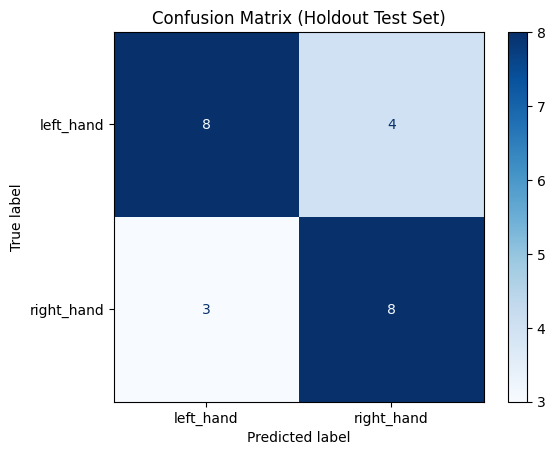

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score)
from scipy.stats import uniform

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42))
])

param_dist = {
    'svc__C': uniform(0.1, 10),  # Regularization strength
    'svc__gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 6)),  # Kernel coefficient
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],  # Different kernel types
    'svc__degree': [2, 3, 4],  # Only relevant if kernel='poly'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_trainval, y_trainval)

best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)
print("Training accuracy (CV avg): ", random_search.best_score_)

y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Holdout Test Set)")
plt.show()